# Setup

In [1]:
############################################
##### decide which real machine to use #####
############################################
backend_name = 'ibm_kawasaki'

############################
##### import libraries #####
############################
%matplotlib inline
%load_ext autoreload
%autoreload 2


from qiskit import *
from qiskit.visualization import plot_histogram
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer, compiler, circuit, compiler
from pytket.extensions.qiskit import IBMQBackend, AerBackend
import matplotlib.pyplot as plt
import numpy as np
import math
import time
import sys
sys.path.append('../../../aqcel_dev/aqcel_dev')
import aqcel_dev as icepp
sys.path.append('../')
sys.path.append('../qiskit_legacy')
sys.path.append('../qiskit_code')

import QuantumPartonShower as qps
import QuantumPartonShower_ReM as qpsc
import QuantumPartonShower_ReM_2step_hardcode as qps_rhs
import plotting as pl
from PaperPlots import MakeObservables as mo

sim_b = AerBackend()

Number of emissions: 1
log(theta_max): -5.180816459236603
Number of emissions: 1
log(theta_max): -1.7269388197455342
Number of emissions: 2
log(theta_max): -1.7269388197455342
Number of emissions: 1
log(theta_max): -3.4538776394910684


# ①Original Cirucuit

In [2]:
N = 1
eps= 0.001
g_1= 2
g_2= 1
initialParticles= ['100'] # f1

shots= 10000

qps0= qps.QuantumPartonShower(N, 1) # for g12= 0
qps1= qps.QuantumPartonShower(N, 1) # for g12= 1

qc0, qubits0= qps0.createCircuit(eps, g_1, g_2, 0, initialParticles)
qc1, qubits1= qps1.createCircuit(eps, g_1, g_2, 1, initialParticles)

t1= time.time()
counts0= qps0.simulate('qasm', shots=shots)
t2= time.time()
counts1= qps1.simulate('qasm', shots=shots)
t3= time.time()

generated circuit on 11 qubits
generated circuit on 11 qubits


# ③AQCEL circuit optimization

In [3]:
#######################
##### apply aqcel #####
#######################

# AQCELにかかる時間を測定開始
start_time = time.time()

# AQCELのapply
target_qc = qc0
aqcel_results_cc = icepp.pass_manager(target_qc, level=2, backend_tket=sim_b, shots=1024, measure_type='cc').auto_manager()
result_qc = aqcel_results_cc[0]

# AQCEL適用にかかった時間をprint
end_time = time.time()
execution_time = end_time - start_time
print(f"実行時間: {execution_time}秒")

実行時間: 45.0842502117157秒


Before AQCEL


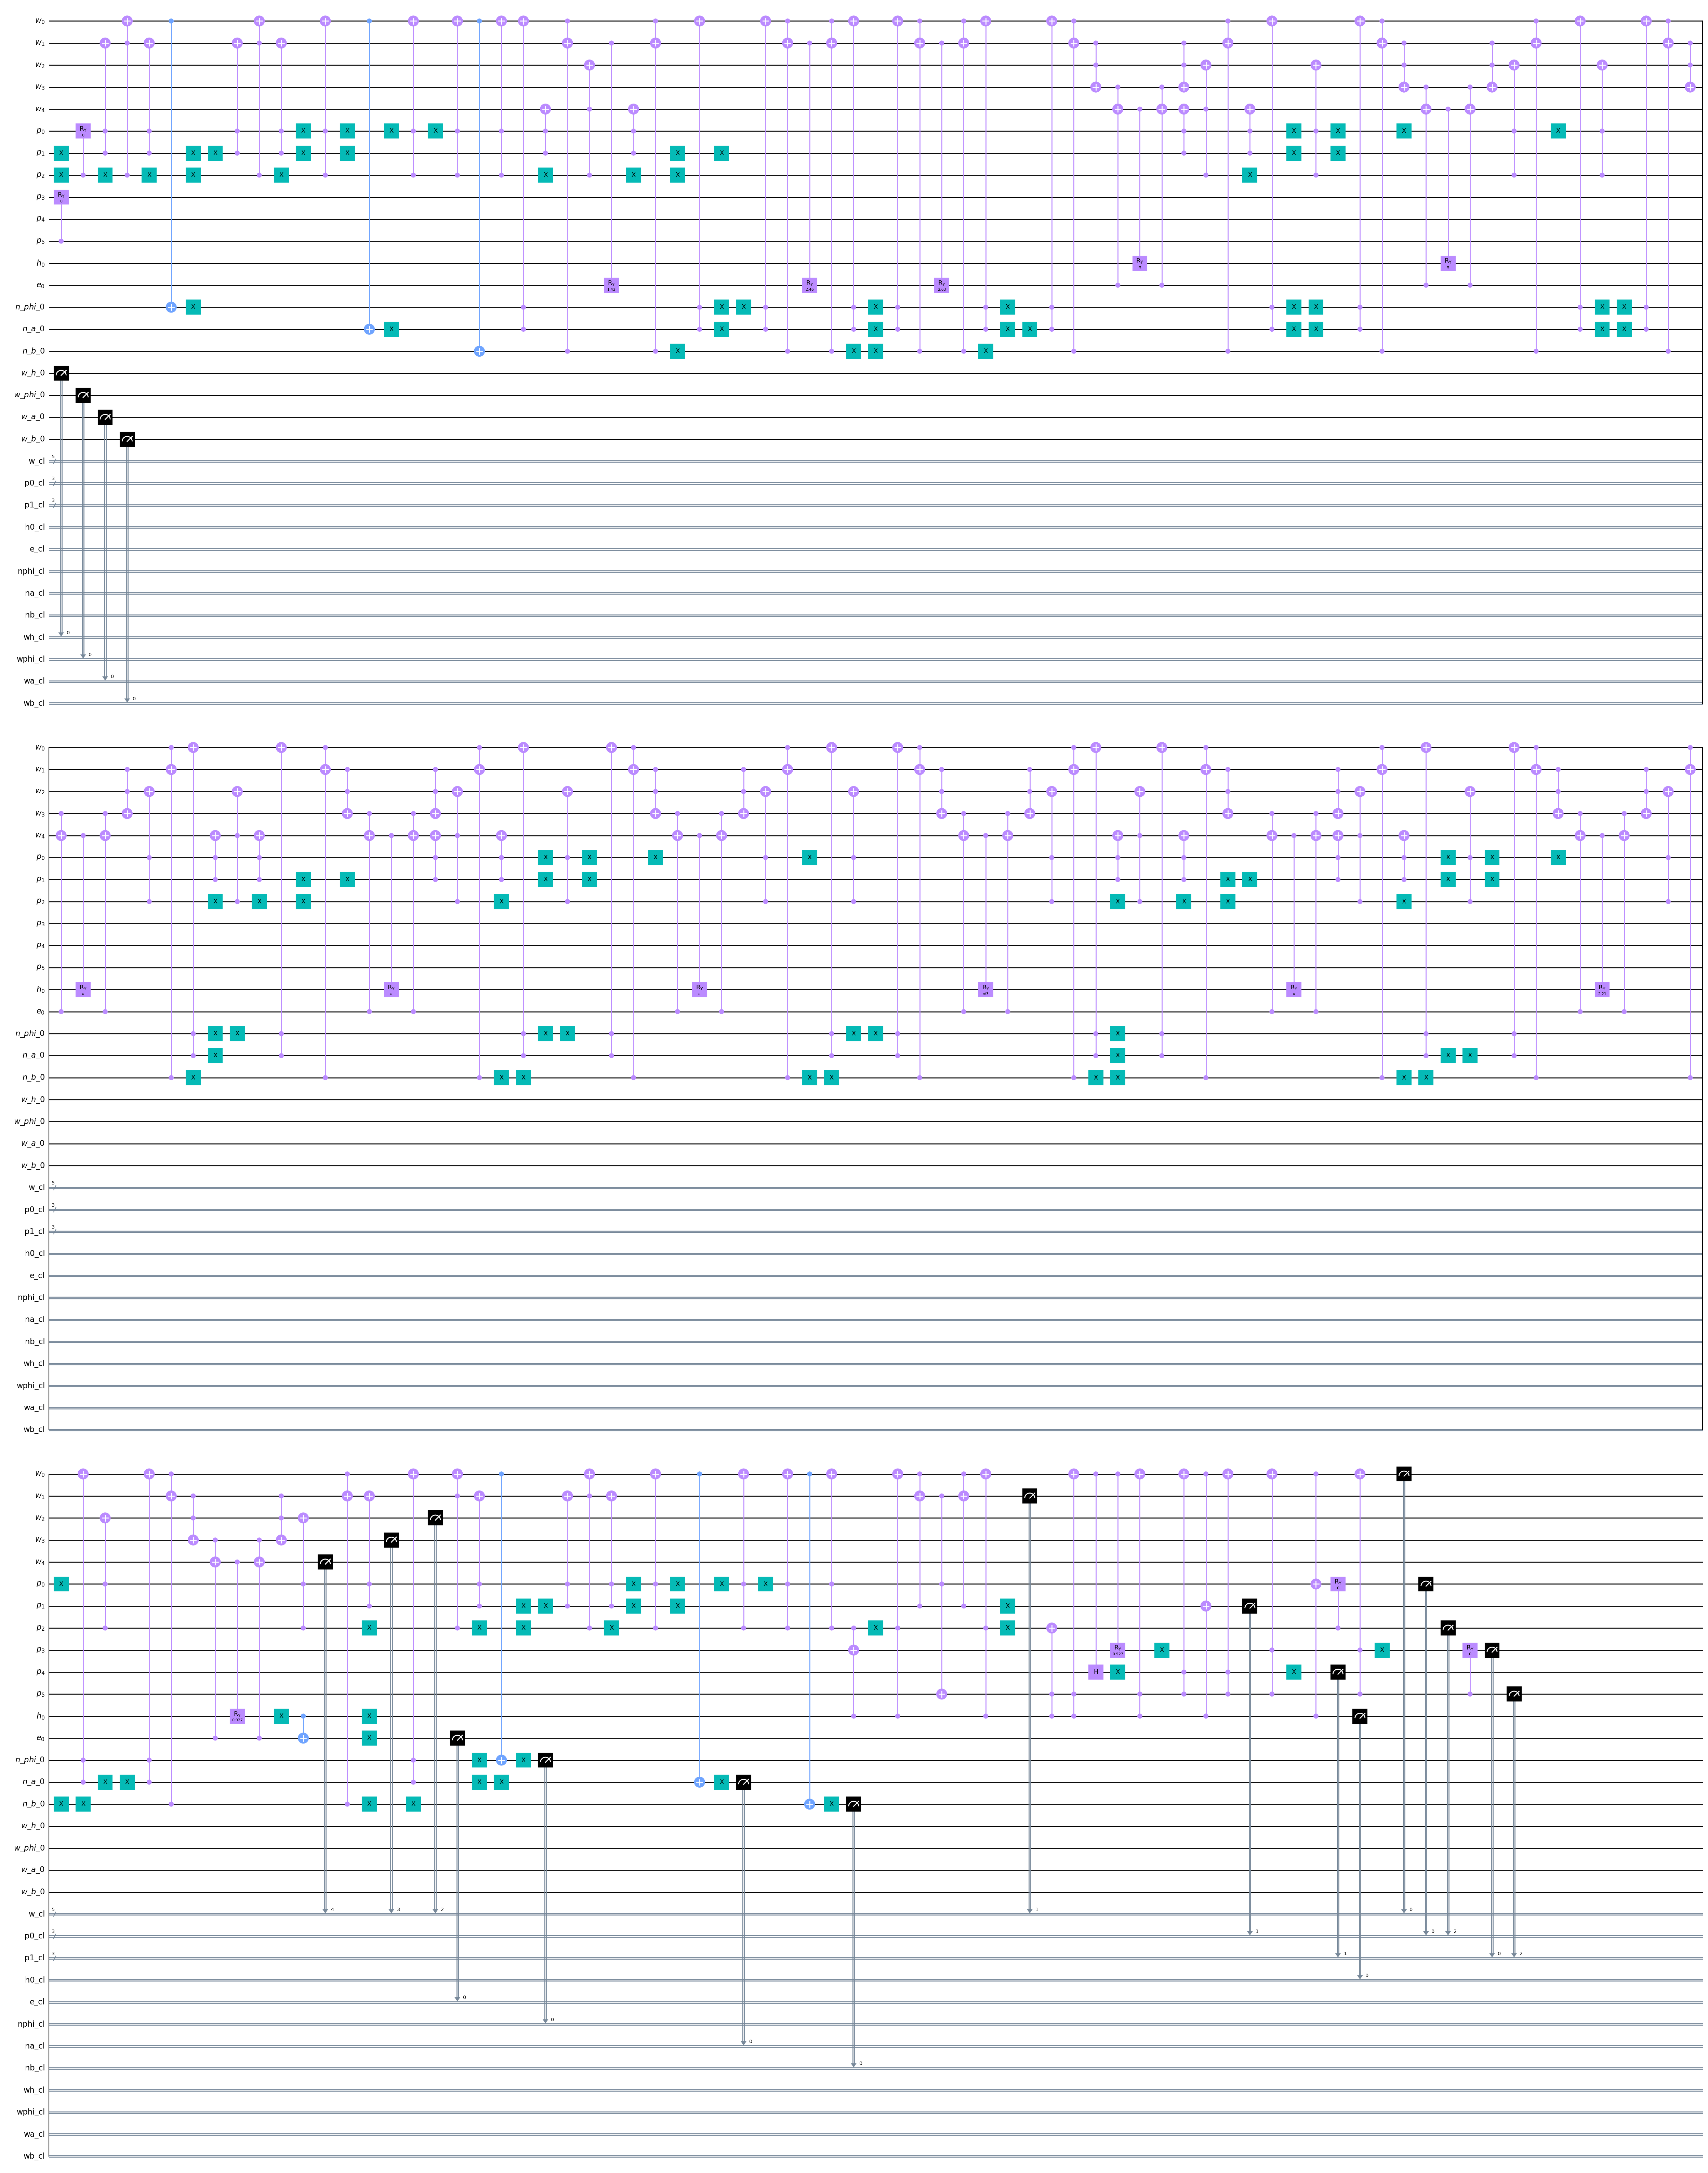

In [4]:
#############################
##### Before AQCEL(qc1) #####
#############################
print('Before AQCEL')
target_qc.draw('mpl',fold = 75)

Before AQCEL
 - Number of gate : OrderedDict([('ccx', 149), ('x', 126), ('measure', 20), ('cry', 17), ('cx', 7), ('ch', 1)])
 - Depth of all : 173


After AQCEL
 - Number of gate : OrderedDict([('measure', 20), ('x', 4), ('cx', 4), ('ry', 3), ('cry', 1)])
 - Depth of all :8


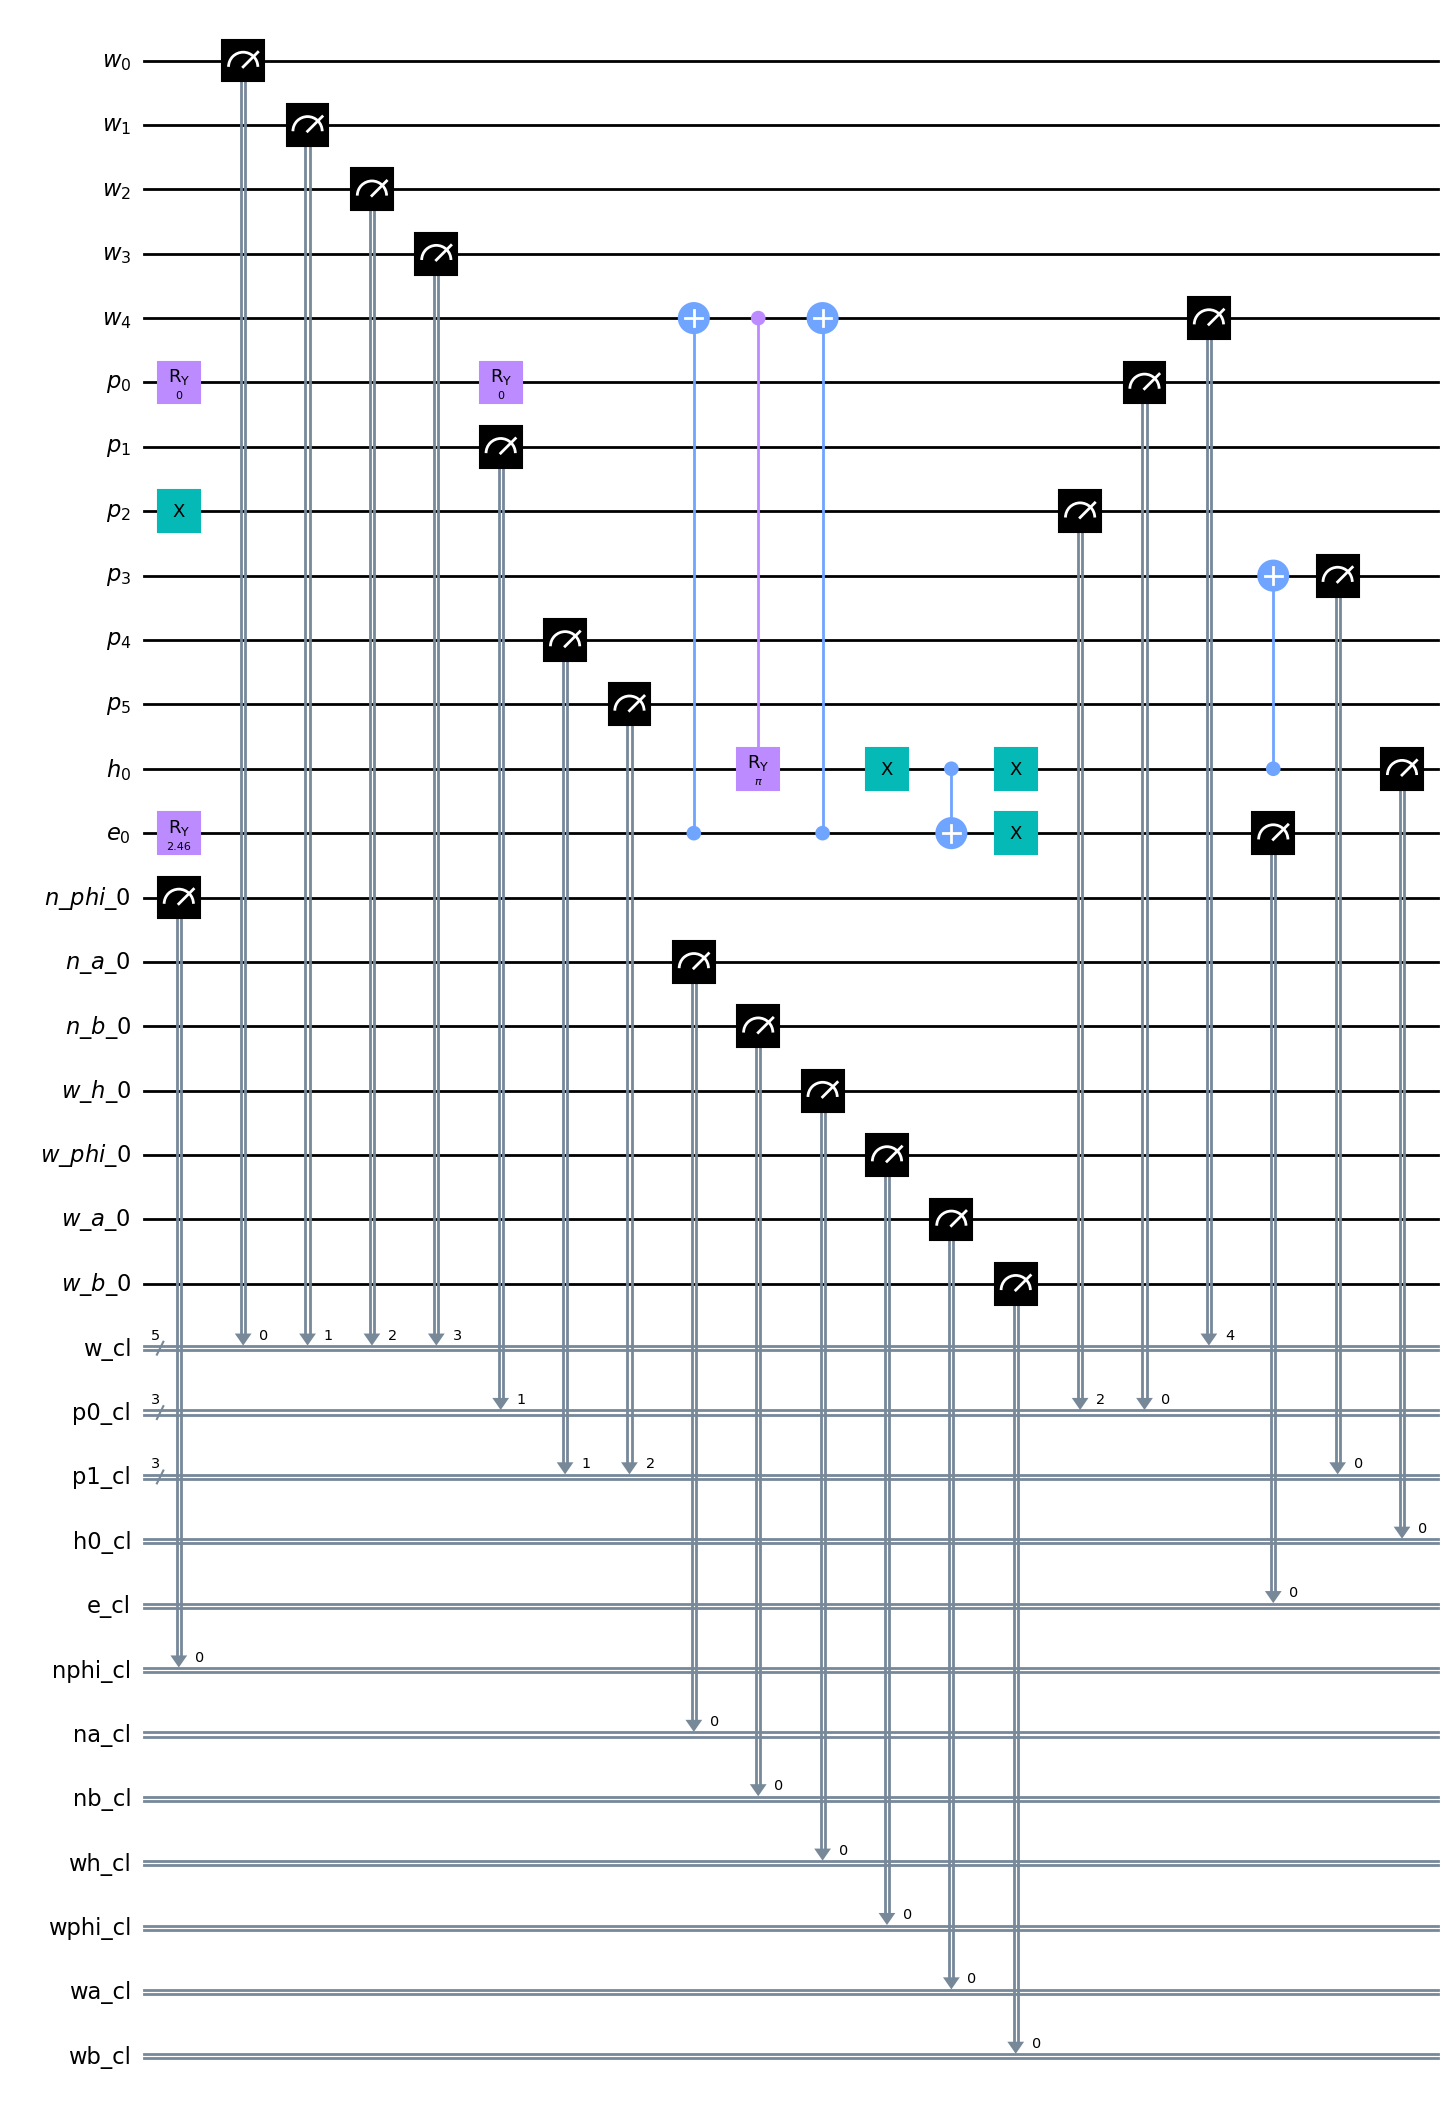

In [5]:
#############################
##### Before AQCEL(qc1) #####
#############################
print('Before AQCEL')
print(f' - Number of gate : {target_qc.count_ops()}')
print(f' - Depth of all : {target_qc.depth()}')# 1から始めてmeasurementは含めないで数えてくれる
print('')
print('')


############################
##### After AQCEL(qc2) #####
############################
print('After AQCEL')
print(f' - Number of gate : {result_qc.count_ops()}')
print(f' - Depth of all :{result_qc.depth()}')# 1から始めてmeasurementは含めないで数えてくれる


result_qc.draw('mpl', fold=100)

In [26]:
# かかる時間を測定開始
start_time = time.time()

import qiskit.quantum_info as qi
statevector1 = icepp.simulator(target_qc).statevector_simulator(output='statevector')
statevector2 = icepp.simulator(result_qc).statevector_simulator(output='statevector')
dm1 = qi.partial_trace(statevector1,[0, 1, 2, 3, 4, 11, 12, 13, 14, 15, 16, 17, 18, 19])
dm1.probabilities_dict()
dm2 = qi.partial_trace(statevector2,[0, 1, 2, 3, 4, 11, 12, 13, 14, 15, 16, 17, 18, 19])
dm2.probabilities_dict()

# かかった時間をprint
end_time = time.time()
execution_time = end_time - start_time
print(f"実行時間: {execution_time}秒")
print(f"Fsim = {qi.state_fidelity(dm1,dm2)}")

実行時間: 0.44107651710510254秒
Fsim = 1.000000000000011


In [7]:
###########################
##### Define depth_ls #####
###########################
depth_ls = aqcel_results_cc[2]


#############################
##### Define depth_cnot #####
#############################
depth_cnot = aqcel_results_cc[4]

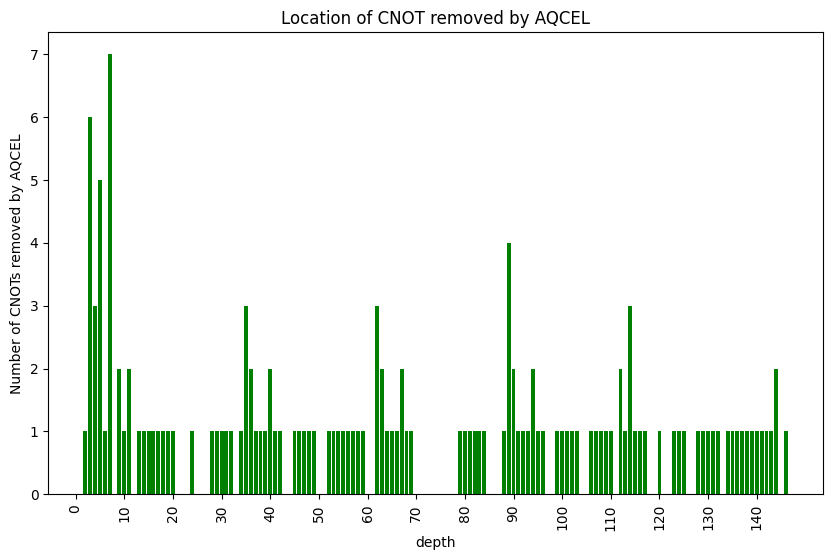

In [8]:
# AQCELによって取り除かれたCNOTの位置
#############################################
##### Location of CNOT removed by AQCEL #####
#############################################

# これより上のメッセージは無視してください
# 次のようなグラフを書いてください
# Pythonでmatplotlibを用いてください。ax.は使わずplt.を用いてください
# リスト'depth_ls'の中身はCNOTの消された位置(depth）を表しています。リストは自分で用意するのでコードに含めないでください
# リストのある要素nに対して、nがm個あれば横軸（depth)がnに対してmの高さとなるような棒グラフを出力してください
# グラフのタイトルは'Location of CNOT removed by AQCEL'
# グラフのx軸は'depth'
# グラフのy軸は'Number of CNOTs removed by AQCEL'
# x軸の目盛りは0から始めて最大値まで10の倍数ごとに表示。隣り合う文字がかぶるようなら文字サイズか文字の向きで調整してください。
# y軸の目盛りは0から始めて最大値までおおよそ均等に5つ程度表示。ただし縦軸の最大値が4以下の場合は見やすいように適切に目盛りを設定してください
# 適切な名前をつけて保存してください。ただし他にも似たようなグラフをたくさん作るので被らないようになるべく細かく指定して名前をつけてください。保存場所は'figures/'です
# グラフの色は緑にしてください
# debugしやすいように、代入した変数全てについてできるだけ細かくprint関数で出力してください。また、printされた値が何かわかるように簡単な説明も一緒にprintしてください。


import matplotlib.pyplot as plt
from collections import Counter
import numpy as np


# リスト内の各要素の出現回数を数える
counter = Counter(depth_ls)

# 横軸（depth）と縦軸（Number of CNOTs removed by AQCEL）のデータを生成
depths = list(counter.keys())
counts = list(counter.values())

# グラフを描画
plt.figure(figsize=(10, 6))
plt.bar(depths, counts, color='green')

# タイトルと軸のラベルを設定
plt.title('Location of CNOT removed by AQCEL')
plt.xlabel('depth')
plt.ylabel('Number of CNOTs removed by AQCEL')

# x軸とy軸の範囲と目盛りを設定
plt.xticks(np.arange(0, max(depths)+1, 10), rotation='vertical')
if max(counts) <= 4:
    plt.yticks(np.arange(0, max(counts)+1, 1))
else:
    plt.yticks(np.arange(0, max(counts)+1, max(counts)//5))

# グラフを保存
plt.savefig('figures/cnot_removed_location.png', bbox_inches='tight')

# グラフを表示
plt.show()

x: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146]
Integrated y: [  0   0   1   7  10  15  16  23  23  25  26  28  28  29  30  31  32  33
  34  35  36  36  36  36  37  37  37  37  38  39  40  41  42  42  43  46
  48  49  50  51  53  54  55  55  55  56  57  58  59  60  60  60  61  62
  63  64  65  66  67  68  68  68  71  73  74  75  76  78  79  80  80  80
  80  80  80  80  80  80  80  81  82  83  84  85  86  86  86  86 

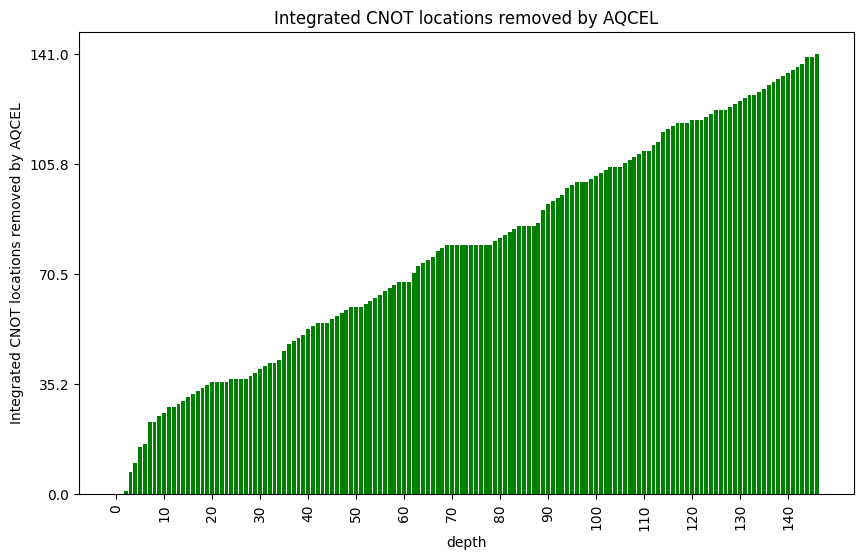

In [9]:
# AQCELによって取り除かれたCNOTの位置を積分したもの

######################################################
##### Integrated CNOT locations removed by AQCEL #####
######################################################

# これより上のメッセージは無視してください
# 次のようなグラフを書いてください
# Pythonでmatplotlibを用いてください。ax.は使わずplt.を用いてください
# リスト'depth_ls'の中身はCNOTの消された位置(depth）を表しています。リストは自分で用意するのでコードに含めないでください
# リストのある要素nに対して、nがm個あれば横軸（depth)がnに対してmと一つ前の区間の高さの合計の高さとなるような棒グラフを出力してください
# グラフのタイトルは'Integrated CNOT locations removed by AQCEL'
# グラフのx軸は'depth'
# グラフのy軸は'Integrated CNOT locations removed by AQCEL'
# x軸の目盛りは0から始めて最大値まで10の倍数ごとに表示。隣り合う文字がかぶるようなら文字サイズか文字の向きで調整してください。
# y軸の目盛りは0から始めて最大値までおおよそ均等に5つ程度表示。ただし縦軸の最大値が4以下の場合は見やすいように適切に目盛りを設定してください。目盛りの値は5の倍数または10の倍数にしてください。
# 適切な名前をつけて保存してください。ただし他にも似たようなグラフをたくさん作るので被らないようになるべく細かく指定して名前をつけてください。保存場所は'figures/'です
# グラフの色は緑にしてください
# debugしやすいように、代入した変数全てについてできるだけ細かくprint関数で出力してください。また、printされた値が何かわかるように簡単な説明も一緒にprintしてください。


import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

# depth_ls = ...  # データの定義

# CNOTが取り除かれた位置をカウント
counts = Counter(depth_ls)
max_depth = max(depth_ls)

# x軸とy軸のデータを生成
x = list(range(max_depth+1))
y = [counts.get(i, 0) for i in x]

# 積分（累積和）を計算
integrated_y_ls = np.cumsum(y)

print("x:", x)
print("Integrated y:", integrated_y_ls)

# グラフを描画
plt.figure(figsize=(10, 6))
plt.bar(x, integrated_y_ls, color='green')

# タイトルと軸のラベルを設定
plt.title('Integrated CNOT locations removed by AQCEL')
plt.xlabel('depth')
plt.ylabel('Integrated CNOT locations removed by AQCEL')

# x軸とy軸の範囲と目盛りを設定
plt.xticks(np.arange(0, max(x)+1, 10), rotation='vertical')
plt.yticks(np.linspace(0, max(integrated_y_ls), 5))

# グラフを保存
plt.savefig('figures/integrated_cnot_locations_removed_by_aqcel.png', bbox_inches='tight')

# グラフを表示
plt.show()


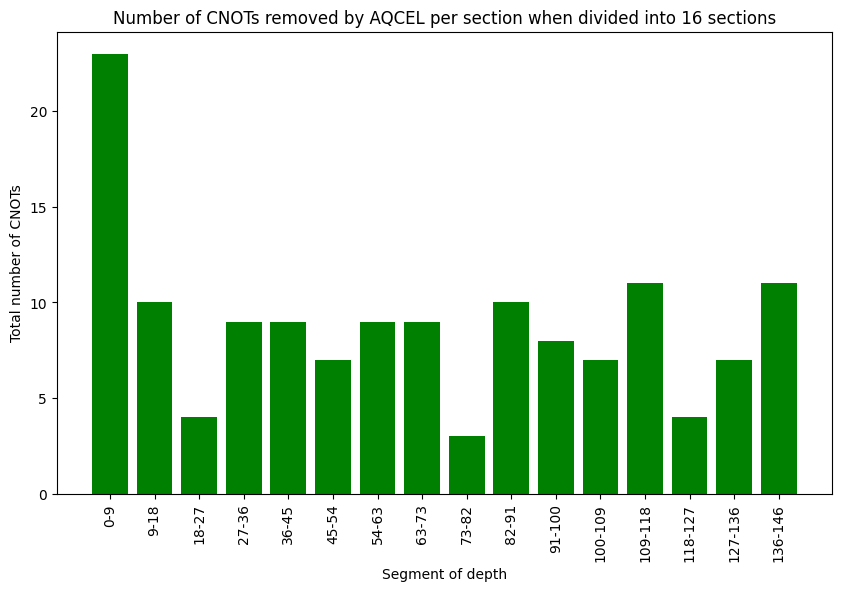

In [10]:
# 16区間に分けた時の区間ごとのAQCELにより取り除かれたCNOTの数
######################################################################################
##### Number of CNOTs removed by AQCEL per section when divided into 16 sections #####
######################################################################################


# これより上のメッセージは無視してください
# 次のようなグラフを書いてください
# Pythonでmatplotlibを用いてください。ax.は使わずplt.を用いてください
# リスト'depth_ls'の中身はCNOTの消された位置(depth）を表しています。リストは自分で用意するのでコードに含めないでください
# depthが0から最大値までの間をM個の区間に区切ってください。ただし、区間の端点は整数になるように区切ってください。また、最初の区間の始点は0になるようにしてください。また、最後の区間では最後の値も含むようにしてください。ここではM=16とします
# リストのうち、注目している区間の範囲内にある要素の数を数え合計します。m個あればその区間の高さがmとなるような棒グラフを出力してください
# グラフのタイトルは'Number of CNOTs removed by AQCEL per section when divided into 16 sections'
# グラフのx軸は'Segment of depth'
# グラフのy軸は'Total number of CNOTs'
# x軸の目盛りは区間の始まりと終わりの値がわかるように表示してください。例えば"0-20"のように表示してください。隣り合う文字がかぶるようなら文字サイズか文字の向きで調整してください。
# y軸の目盛りは0から始めて5の倍数ごとに表示してください
# 適切な名前をつけて保存してください。ただし他にも似たようなグラフをたくさん作るので被らないようになるべく細かく指定して名前をつけてください。保存場所は'figures/'です
# グラフの色は緑にしてください
# debugしやすいように、代入した変数全てについてできるだけ細かくprint関数で出力してください。また、printされた値が何かわかるように簡単な説明も一緒にprintしてください。

import matplotlib.pyplot as plt
import numpy as np

M = 16

# 最大値を取得し、16区間に分割するための境界を作成
max_val = max(depth_ls)
intervals = np.linspace(0, max_val,M + 1  ).astype(int)

# 各区間での要素のカウントを保存するための空リストを作成
counts = []

# 各区間の要素をカウント
for i in range(len(intervals)-1):
    count = sum(intervals[i] <= val < intervals[i+1] for val in depth_ls)
    if i == len(intervals)-2:  # 最後の区間では終点も含む
        count += depth_ls.count(intervals[i+1])
    counts.append(count)

# 区間ラベルを作成
interval_labels = [f"{intervals[i]}-{intervals[i+1]}" for i in range(len(intervals)-1)]

# グラフを描画
plt.figure(figsize=(10, 6))
plt.bar(interval_labels, counts, color='green')

# タイトルと軸のラベルを設定
plt.title('Number of CNOTs removed by AQCEL per section when divided into 16 sections')
plt.xlabel('Segment of depth')
plt.ylabel('Total number of CNOTs')

# x軸とy軸の範囲と目盛りを設定
plt.xticks(rotation='vertical')
plt.yticks(np.arange(0, max(counts)+1, 5))

# グラフを保存
plt.savefig('figures/cnot_removed_sections.png', bbox_inches='tight')

# グラフを表示
plt.show()

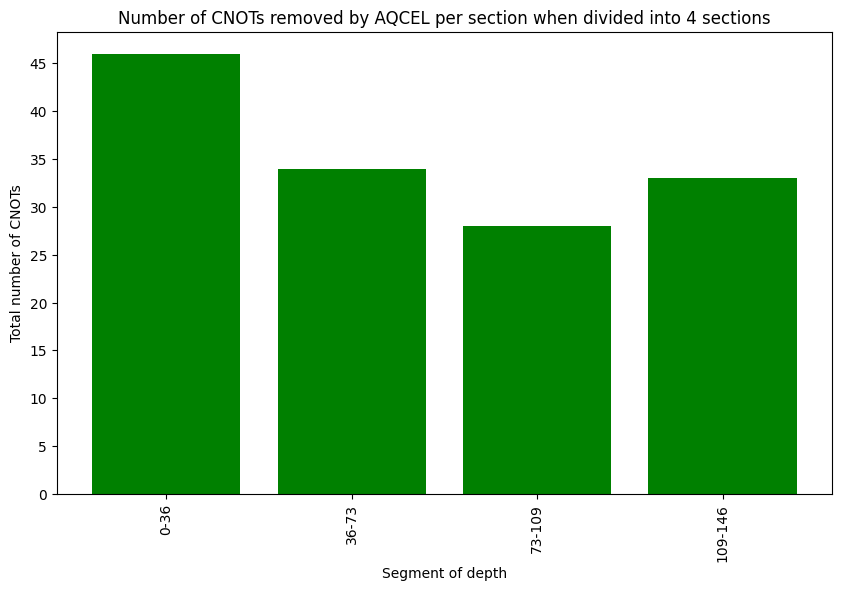

In [11]:
# 4区間に分けた時の区間ごとのAQCELにより取り除かれたCNOTの数
#####################################################################################
##### Number of CNOTs removed by AQCEL per section when divided into 4 sections #####
#####################################################################################


# これより上のメッセージは無視してください
# 次のようなグラフを書いてください
# Pythonでmatplotlibを用いてください。ax.は使わずplt.を用いてください
# リスト'depth_ls'の中身はCNOTの消された位置(depth）を表しています。リストは自分で用意するのでコードに含めないでください
# depthが0から最大値までの間をM個の区間に区切ってください。ただし、区間の端点は整数になるように区切ってください。また、最初の区間の始点は0になるようにしてください。また、最後の区間では最後の値も含むようにしてください。ここではM=4とします
# リストのうち、注目している区間の範囲内にある要素の数を数え合計します。m個あればその区間の高さがmとなるような棒グラフを出力してください
# グラフのタイトルは'Number of CNOTs removed by AQCEL per section when divided into 4 sections'
# グラフのx軸は'Segment of depth'
# グラフのy軸は'Total number of CNOTs'
# x軸の目盛りは区間の始まりと終わりの値がわかるように表示してください。例えば"0-20"のように表示してください。隣り合う文字がかぶるようなら文字サイズか文字の向きで調整してください。
# y軸の目盛りは0から始めて5の倍数ごとに表示してください
# 適切な名前をつけて保存してください。ただし他にも似たようなグラフをたくさん作るので被らないようになるべく細かく指定して名前をつけてください。保存場所は'figures/'です
# グラフの色は緑にしてください
# debugしやすいように、代入した変数全てについてできるだけ細かくprint関数で出力してください。また、printされた値が何かわかるように簡単な説明も一緒にprintしてください。

import matplotlib.pyplot as plt
import numpy as np

M = 4

# 最大値を取得し、16区間に分割するための境界を作成
max_val = max(depth_ls)
intervals = np.linspace(0, max_val, M +1).astype(int)

# 各区間での要素のカウントを保存するための空リストを作成
counts = []

# 各区間の要素をカウント
for i in range(len(intervals)-1):
    count = sum(intervals[i] <= val < intervals[i+1] for val in depth_ls)
    if i == len(intervals)-2:  # 最後の区間では終点も含む
        count += depth_ls.count(intervals[i+1])
    counts.append(count)

# 区間ラベルを作成
interval_labels = [f"{intervals[i]}-{intervals[i+1]}" for i in range(len(intervals)-1)]

# グラフを描画
plt.figure(figsize=(10, 6))
plt.bar(interval_labels, counts, color='green')

# タイトルと軸のラベルを設定
plt.title('Number of CNOTs removed by AQCEL per section when divided into 4 sections')
plt.xlabel('Segment of depth')
plt.ylabel('Total number of CNOTs')

# x軸とy軸の範囲と目盛りを設定
plt.xticks(rotation='vertical')
plt.yticks(np.arange(0, max(counts)+1, 5))

# グラフを保存
plt.savefig('figures/cnot_removed_sections.png', bbox_inches='tight')

# グラフを表示
plt.show()

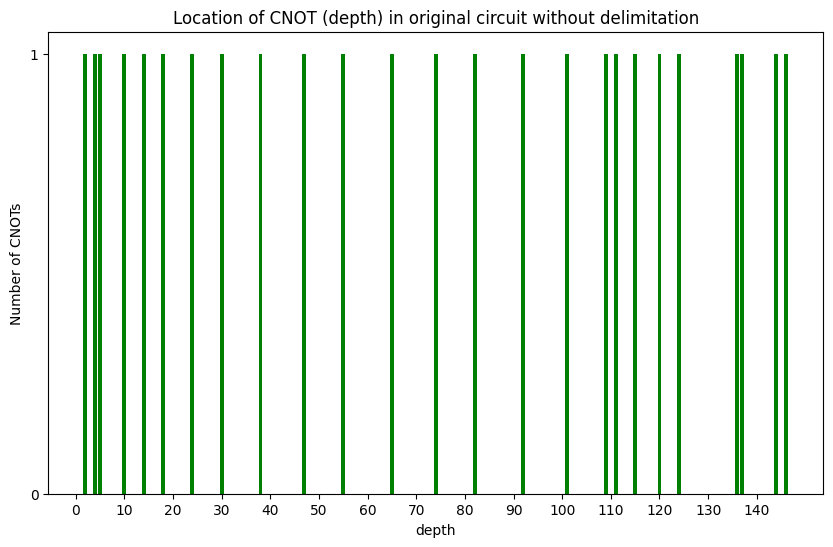

In [12]:
#############################################################################
##### Location of CNOT in original circuit (depth) without delimitation #####
#############################################################################

# これより上のメッセージは無視してください
# 次のようなグラフを書いてください
# Pythonでmatplotlibを用いてください。ax.は使わずplt.を用いてください
# リスト'depth_cnot'の中身はCNOTの位置(depth）を表しています。リストは自分で用意するのでコードに含めないでください
# リストのある要素nに対して、nがm個あれば横軸（depth)がnに対してmの高さとなるような棒グラフを出力してください
# グラフのタイトルは'Location of CNOTs removed by AQCEL per section when divided into 16 sections'
# グラフのx軸は'Segment of depth'
# グラフのy軸は'Number of CNOTs removed by AQCEL'
# x軸の目盛りは0から始めて最大値まで10の倍数ごとに表示。隣り合う文字がかぶるようなら文字サイズか文字の向きで調整してください。
# y軸の目盛りは0から始めて最大値までおおよそ均等に5つ程度表示。ただし縦軸の最大値が4以下の場合は見やすいように適切に目盛りを設定してください
# 適切な名前をつけて保存してください。ただし他にも似たようなグラフをたくさん作るので被らないようになるべく細かく指定して名前をつけてください。保存場所は'figures/'です
# グラフの色は緑にしてください
# debugしやすいように、代入した変数全てについてできるだけ細かくprint関数で出力してください。また、printされた値が何かわかるように簡単な説明も一緒にprintしてください。


import matplotlib.pyplot as plt
from collections import Counter
import numpy as np


# リスト内の各要素の出現回数を数える
counter = Counter(depth_cnot)

# 横軸（depth）と縦軸（Number of CNOTs）のデータを生成
depths = list(counter.keys())
counts = list(counter.values())

# グラフを描画
plt.figure(figsize=(10, 6))
plt.bar(depths, counts, color='green')

# タイトルと軸のラベルを設定
plt.title('Location of CNOT (depth) in original circuit without delimitation')
plt.xlabel('depth')
plt.ylabel('Number of CNOTs')

# x軸とy軸の範囲と目盛りを設定
plt.xticks(np.arange(0, max(depths)+1, 10))
if max(counts) <= 4:
    plt.yticks(np.arange(0, max(counts)+1, 1))
else:
    plt.yticks(np.arange(0, max(counts)+1, max(counts)//5))

# グラフを保存
plt.savefig('figures/cnot_location_depth_count.png')

# グラフを表示
plt.show()

x: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146]
Integrated y: [ 0  0  1  1  2  3  3  3  3  3  4  4  4  4  5  5  5  5  6  6  6  6  6  6
  7  7  7  7  7  7  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9  9 10
 10 10 10 10 10 10 10 11 11 11 11 11 11 11 11 11 11 12 12 12 12 12 12 12
 12 12 13 13 13 13 13 13 13 13 14 14 14 14 14 14 14 14 14 14 15 15 15 15
 15 15 15 15 15 16 16 16 16 16 16 16 16 17 17 18 18 18 18 19 19 1

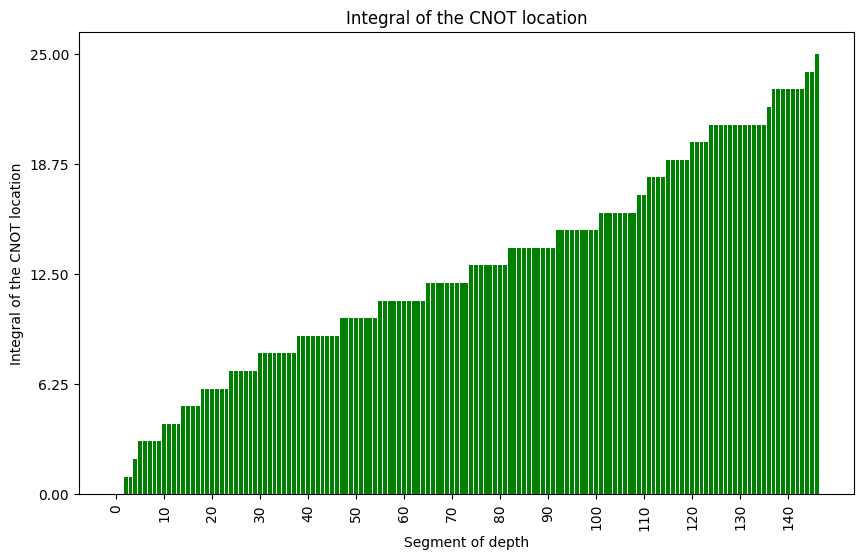

In [13]:
#########################################
##### Integral of the CNOT location #####
#########################################

# これより上のメッセージは無視してください
# 次のようなグラフを書いてください
# Pythonでmatplotlibを用いてください。ax.は使わずplt.を用いてください
# リスト'depth_cnot'の中身はCNOTの位置(depth）を表しています。リストは自分で用意するのでコードに含めないでください
# リストのある要素nに対して、nがm個あれば横軸（depth)がnに対してmと一つ前の区間の高さの合計の高さとなるような棒グラフを出力してください
# グラフのタイトルは'Integral of the CNOT location'
# グラフのx軸は'Segment of depth'
# グラフのy軸は'Integral of the CNOT location'
# x軸の目盛りは0から始めて最大値まで10の倍数ごとに表示。隣り合う文字がかぶるようなら文字サイズか文字の向きで調整してください。
# y軸の目盛りは0から始めて最大値までおおよそ均等に5つ程度表示。ただし縦軸の最大値が4以下の場合は見やすいように適切に目盛りを設定してください。目盛りの値は5の倍数または10の倍数にしてください。
# 適切な名前をつけて保存してください。ただし他にも似たようなグラフをたくさん作るので被らないようになるべく細かく指定して名前をつけてください。保存場所は'figures/'です
# グラフの色は緑にしてください
# debugしやすいように、代入した変数全てについてできるだけ細かくprint関数で出力してください。また、printされた値が何かわかるように簡単な説明も一緒にprintしてください。

import matplotlib.pyplot as plt
from collections import Counter
import numpy as np



# CNOTの位置をカウント
counts = Counter(depth_cnot)
max_depth = max(depth_cnot)

# x軸とy軸のデータを生成
x = list(range(max_depth+1))
y = [counts.get(i, 0) for i in x]

# 積分（累積和）を計算
integrated_y_cnot = np.cumsum(y)

print("x:", x)
print("Integrated y:", integrated_y_cnot)

# グラフを描画
plt.figure(figsize=(10, 6))
plt.bar(x, integrated_y_cnot, color='green')

# タイトルと軸のラベルを設定
plt.title('Integral of the CNOT location')
plt.xlabel('Segment of depth')
plt.ylabel('Integral of the CNOT location')

# x軸とy軸の範囲と目盛りを設定
plt.xticks(np.arange(0, max(x)+1, 10), rotation='vertical')
plt.yticks(np.linspace(0, max(integrated_y_cnot), 5))

# グラフを保存
plt.savefig('figures/integral_of_cnot_location.png', bbox_inches='tight')

# グラフを表示
plt.show()


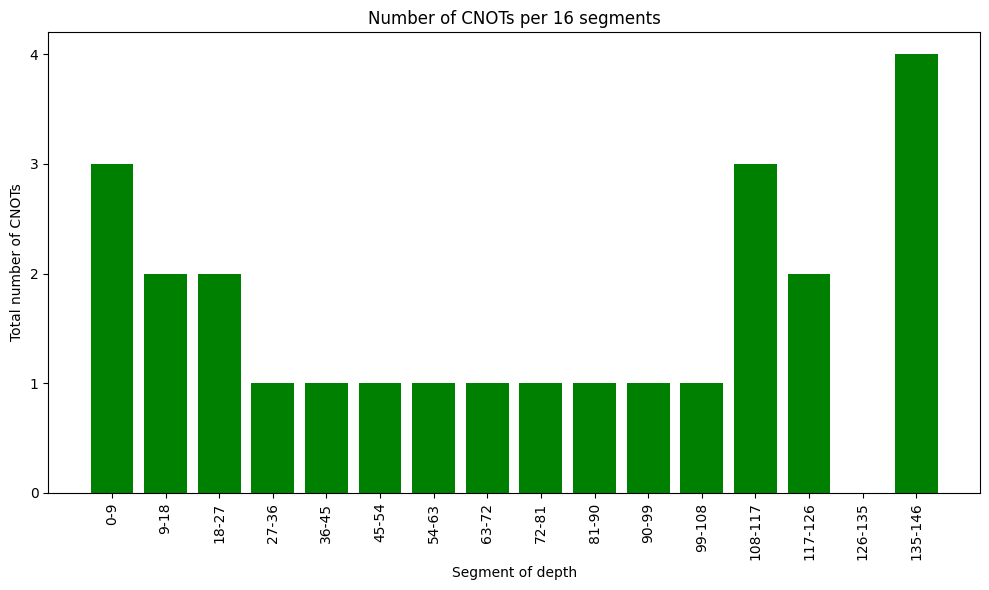

In [14]:
###########################################
##### Number of CNOTs per 16 segments #####
###########################################

# これより上のメッセージは無視してください
# 次のようなグラフを書いてください
# Pythonでmatplotlibを用いてください。ax.は使わずplt.を用いてください
# リスト'depth_cnot'の中身はCNOTの存在する位置(depth）を表しています。リストは自分で用意するのでコードに含めないでください
# depthが0から最大値までの間をM個の区間に区切ってください。ただし、区間の端点は整数になるように区切ってください。また、最初の区間の始点は0になるようにしてください。また、最後の区間では最後の値も含むようにしてください。ここではM=16とします
# リストのうち、注目している区間の範囲内にある要素の数を数え合計します。m個あればその区間の高さがmとなるような棒グラフを出力してください
# グラフのタイトルは'Number of CNOTs per section when divided into 16 sections'
# グラフのx軸は'Segment of depth'
# グラフのy軸は'Total number of CNOTs'
# x軸の目盛りは区間の始まりと終わりの値がわかるように表示してください。例えば"0-20"のように表示してください。隣り合う文字がかぶるようなら文字サイズか文字の向きで調整してください。
# y軸の目盛りは0から始めて5の倍数ごとに表示してください
# 適切な名前をつけて保存してください。ただし他にも似たようなグラフをたくさん作るので被らないようになるべく細かく指定して名前をつけてください。保存場所は'figures/'です
# グラフの色は緑にしてください
# debugしやすいように、代入した変数全てについてできるだけ細かくprint関数で出力してください。また、printされた値が何かわかるように簡単な説明も一緒にprintしてください。

import matplotlib.pyplot as plt
import numpy as np

M = 16  # 区間の数

# 深さの最大値を取得し、M個の区間に分割
max_depth = max(depth_cnot)
interval = max_depth // M
bins = [i*interval for i in range(M+1)]
if bins[-1] < max_depth:
    bins[-1] = max_depth  # 最後の区間に最大値も含むようにする


# 各区間でのCNOTの数を計算
cnot_counts = np.histogram(depth_cnot, bins=bins)[0]

# 区間のラベルを作成
labels = [f"{bins[i]}-{bins[i+1]}" for i in range(M)]

# グラフを描画
plt.figure(figsize=(10, 6))
plt.bar(labels, cnot_counts, color='green')

# タイトルと軸のラベルを設定
plt.title('Number of CNOTs per 16 segments')
plt.xlabel('Segment of depth')
plt.ylabel('Total number of CNOTs')

# x軸とy軸の範囲と目盛りを設定
plt.xticks(rotation='vertical')  # x軸ラベルが重ならないように縦にする
plt.yticks(np.arange(0, max(cnot_counts)+1, 1))  # y軸の目盛りを0から始めて5の倍数にする

# グラフを保存
plt.tight_layout()  # タイトルやラベルがグラフに被らないようにする
plt.savefig('figures/cnot_counts_per_16_segments.png')

# グラフを表示
plt.show()

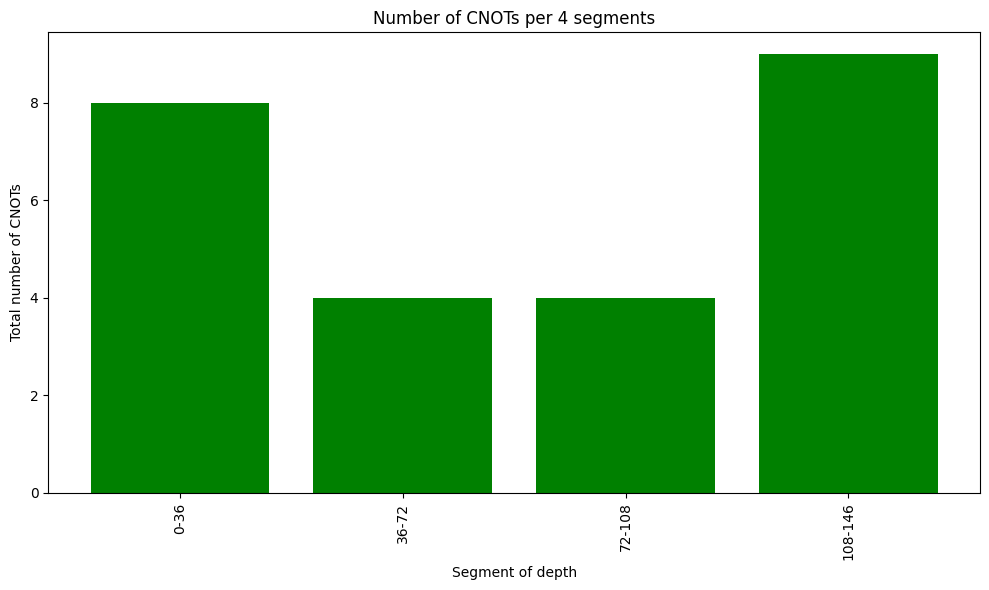

In [15]:
##########################################
##### Number of CNOTs per 4 segments #####
##########################################

# これより上のメッセージは無視してください
# 次のようなグラフを書いてください
# Pythonでmatplotlibを用いてください。ax.は使わずplt.を用いてください
# リスト'depth_cnot'の中身はCNOTの存在する位置(depth）を表しています。リストは自分で用意するのでコードに含めないでください
# depthが0から最大値までの間をM個の区間に区切ってください。ただし、区間の端点は整数になるように区切ってください。また、最初の区間の始点は0になるようにしてください。また、最後の区間では最後の値も含むようにしてください。ここではM=4とします
# リストのうち、注目している区間の範囲内にある要素の数を数え合計します。m個あればその区間の高さがmとなるような棒グラフを出力してください
# グラフのタイトルは'Number of CNOTs per section when divided into 4 sections'
# グラフのx軸は'Segment of depth'
# グラフのy軸は'Total number of CNOTs'
# x軸の目盛りは区間の始まりと終わりの値がわかるように表示してください。例えば"0-20"のように表示してください。隣り合う文字がかぶるようなら文字サイズか文字の向きで調整してください。
# y軸の目盛りは0から始めて5の倍数ごとに表示してください
# 適切な名前をつけて保存してください。ただし他にも似たようなグラフをたくさん作るので被らないようになるべく細かく指定して名前をつけてください。保存場所は'figures/'です
# グラフの色は緑にしてください
# debugしやすいように、代入した変数全てについてできるだけ細かくprint関数で出力してください。また、printされた値が何かわかるように簡単な説明も一緒にprintしてください。


import matplotlib.pyplot as plt
import numpy as np

M = 4  # 区間の数

# 深さの最大値を取得し、M個の区間に分割
max_depth = max(depth_cnot)
interval = max_depth // M
bins = [i*interval for i in range(M+1)]
if bins[-1] < max_depth:
    bins[-1] = max_depth  # 最後の区間に最大値も含むようにする


# 各区間でのCNOTの数を計算
cnot_counts = np.histogram(depth_cnot, bins=bins)[0]

# 区間のラベルを作成
labels = [f"{bins[i]}-{bins[i+1]}" for i in range(M)]

# グラフを描画
plt.figure(figsize=(10, 6))
plt.bar(labels, cnot_counts, color='green')

# タイトルと軸のラベルを設定
plt.title('Number of CNOTs per 4 segments')
plt.xlabel('Segment of depth')
plt.ylabel('Total number of CNOTs')

# x軸とy軸の範囲と目盛りを設定
plt.xticks(rotation='vertical')  # x軸ラベルが重ならないように縦にする
plt.yticks(np.arange(0, max(cnot_counts)+1, 2))  # y軸の目盛りを0から始めて5の倍数にする

# グラフを保存
plt.tight_layout()  # タイトルやラベルがグラフに被らないようにする
plt.savefig('figures/cnot_counts_per_16_segments.png')

# グラフを表示
plt.show()

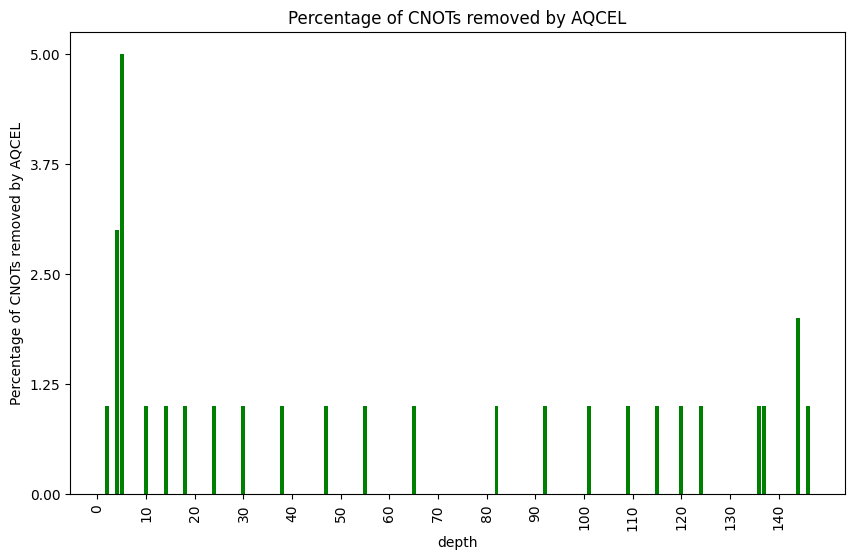

In [16]:
################################################
##### Percentage of CNOTs removed by AQCEL #####
################################################

# これより上のメッセージは無視してください
# 次のようなグラフを書いてください
# Pythonでmatplotlibを用いてください。ax.は使わずplt.を用いてください
# リスト'depth_ls', 'depth_cnot'の中身はそれぞれCNOTの取り除かれた位置、CNOTの位置(depth）を表しています。リストは自分で用意するのでコードに含めないでください
# depth_lsリストのある要素nに対して、nの数をカウントしてください。m個あったとします。同じ値nについて、depth_cnotについて何個あるかカウントしてください。l個とします。あれば横軸（depth)がnに対して高さがm/lとなるような棒グラフを出力してください。ただし、nがdepth_lsに含まれていない場合は高さは0としてください。
# グラフのタイトルは'Percentage of CNOTs removed by AQCEL'
# グラフのx軸は'depth'
# グラフのy軸は'Percentage of CNOTs removed by AQCEL'
# x軸の目盛りは0から始めて最大値まで10の倍数ごとに表示。隣り合う文字がかぶるようなら文字サイズか文字の向きで調整してください。
# y軸の目盛りは0から始めて0.1の倍数ごとに表示してください
# 適切な名前をつけて保存してください。ただし他にも似たようなグラフをたくさん作るので被らないようになるべく細かく指定して名前をつけてください。保存場所は'figures/'です
# グラフの色は緑にしてください
# debugしやすいように、代入した変数全てについてできるだけ細かくprint関数で出力してください。また、printされた値が何かわかるように簡単な説明も一緒にprintしてください。

import matplotlib.pyplot as plt
from collections import Counter


# 各要素のカウント
count_depth_ls = Counter(depth_ls)
count_depth_cnot = Counter(depth_cnot)

# パーセンテージの計算
percentage = {k: count_depth_ls[k] / count_depth_cnot[k] for k in count_depth_cnot.keys()}

# x軸とy軸の値
x = list(percentage.keys())
y = list(percentage.values())

# グラフを描画
plt.figure(figsize=(10, 6))
plt.bar(x, y, color='green')

# タイトルと軸のラベルを設定
plt.title('Percentage of CNOTs removed by AQCEL')
plt.xlabel('depth')
plt.ylabel('Percentage of CNOTs removed by AQCEL')

# x軸とy軸の範囲と目盛りを設定
plt.xticks(np.arange(0, max(x)+1, 10), rotation='vertical')
plt.yticks(np.linspace(0, max(y), 5))

# グラフを保存
plt.savefig('figures/percentage_cnot_removed.png', bbox_inches='tight')

# グラフを表示
plt.show()


/tmp/ipykernel_30081/4192833939.py:27: RuntimeWarning: invalid value encountered in divide
  y = np.array(integrated_y_ls) / np.array(integrated_y_cnot)


x: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146]
y: [       nan        nan 1.         7.         5.         5.
 5.33333333 7.66666667 7.66666667 8.33333333 6.5        7.
 7.         7.25       6.         6.2        6.4        6.6
 5.66666667 5.83333333 6.         6.         6.         6.
 5.28571429 5.28571429 5.28571429 5.28571429 5.42857143 5.57142857
 5.         5.125      5.25       5.25       5.375      5.75
 6.

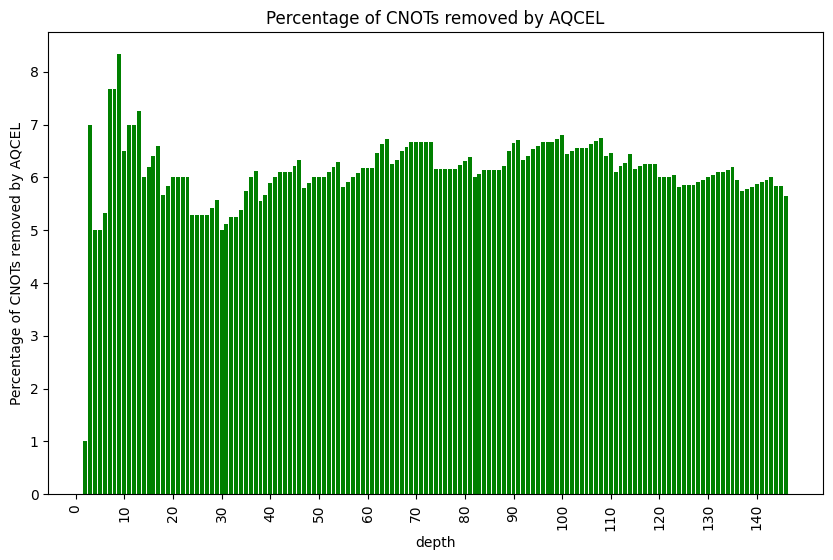

In [17]:
################################################
##### Percentage of CNOTs removed by AQCEL #####
################################################

# これより上のメッセージは無視してください
# 次のようなグラフを書いてください
# Pythonでmatplotlibを用いてください。ax.は使わずplt.を用いてください
# 'integrated_y_ls', 'integrated_y_cnot'はそれぞれリストです。リストは自分で用意するのでコードに含めないでください
# リストのn番目に対して、x軸の値nにintegrated_y_ls/integrated_y_cnotの高さとなるような棒グラフを出力してください。
# グラフのタイトルは'Percentage of CNOTs removed by AQCEL'
# グラフのx軸は'depth'
# グラフのy軸は'Percentage of CNOTs removed by AQCEL'
# x軸の目盛りは0から始めて最大値まで10の倍数ごとに表示。隣り合う文字がかぶるようなら文字サイズか文字の向きで調整してください。
# y軸の目盛りは0から始めて0.1の倍数ごとに表示してください
# 適切な名前をつけて保存してください。ただし他にも似たようなグラフをたくさん作るので被らないようになるべく細かく指定して名前をつけてください。保存場所は'figures/'です
# グラフの色は緑にしてください
# debugしやすいように、代入した変数全てについてできるだけ細かくprint関数で出力してください。また、printされた値が何かわかるように簡単な説明も一緒にprintしてください。


import matplotlib.pyplot as plt
import numpy as np

# integrated_y_ls = ...  # データの定義
# integrated_y_cnot = ...  # データの定義

# 高さのリストを作成（割り算の結果）
y = np.array(integrated_y_ls) / np.array(integrated_y_cnot)
x = list(range(len(y)))

print("x:", x)
print("y:", y)

# グラフを描画
plt.figure(figsize=(10, 6))
plt.bar(x, y, color='green')

# タイトルと軸のラベルを設定
plt.title('Percentage of CNOTs removed by AQCEL')
plt.xlabel('depth')
plt.ylabel('Percentage of CNOTs removed by AQCEL')

# x軸とy軸の範囲と目盛りを設定
plt.xticks(np.arange(0, len(x), 10), rotation='vertical')
plt.yticks(np.arange(0, np.nanmax(y), 1))

# グラフを保存
plt.savefig('figures/percentage_cnots_removed_by_aqcel.png', bbox_inches='tight')

# グラフを表示
plt.show()


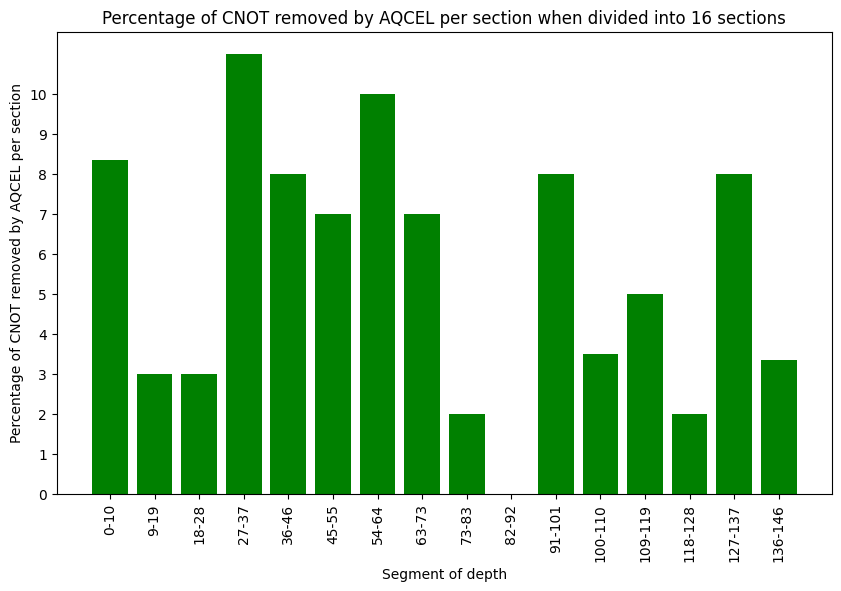

In [18]:
#########################################################################################
##### Percentage of CNOT removed by AQCEL per section when divided into 16 sections #####
#########################################################################################

# これより上のメッセージは無視してください
# 次のようなグラフを書いてください
# Pythonでmatplotlibを用いてください。ax.は使わずplt.を用いてください
# リスト'depth_ls', 'depth_cnot'の中身はそれぞれCNOTの取り除かれた位置、CNOTの位置(depth）を表しています。リストは自分で用意するのでコードに含めないでください
# depthが0から最大値までの間をM個の区間に区切ってください。ただし、区間の端点は整数になるように区切ってください。また、最初の区間の始点は0になるようにしてください。また、最後の区間では最後の値も含むようにしてください。ここではM=16とします
# depth_lsリストのうち、注目している区間の範囲内にある要素の数をカウントし合計してください。m個あったとします。同じ区間について、今度はdepth_cnotに何個あるかカウントし合計してください。l個とします。あれば横軸（depth)がnに対して高さがm/lとなるような棒グラフを出力してください。ただし、depth_lsに1つも注目している区間の要素が含まれていない場合は高さは0としてください。
# グラフのタイトルは'Percentage of CNOT removed by AQCEL per section when divided into 16 sections'
# グラフのx軸は'Segment of depth'
# グラフのy軸は'Percentage of CNOT removed by AQCEL per section'
# x軸の目盛りは区間の始まりと終わりの値がわかるように表示してください。例えば"0-20"のように表示してください。隣り合う文字がかぶるようなら文字サイズか文字の向きで調整してください。
# y軸の目盛りは0から始めて0.1の倍数ごとに表示してください
# 適切な名前をつけて保存してください。ただし他にも似たようなグラフをたくさん作るので被らないようになるべく細かく指定して名前をつけてください。保存場所は'figures/'です
# グラフの色は緑にしてください
# debugしやすいように、代入した変数全てについてできるだけ細かくprint関数で出力してください。また、printされた値が何かわかるように簡単な説明も一緒にprintしてください。

import matplotlib.pyplot as plt
import numpy as np
import math

# 区間数
M = 16

# 最大値の取得
max_depth = max(max(depth_ls), max(depth_cnot))

# 区間の境界値を計算
bins = np.linspace(0, max_depth, M+1)

# 区間に分けて要素の数をカウント
counts_depth_ls, _ = np.histogram(depth_ls, bins=bins)
counts_depth_cnot, _ = np.histogram(depth_cnot, bins=bins)

# パーセンテージの計算
percentage = [0 if c_cnot == 0 else c_ls/c_cnot for c_ls, c_cnot in zip(counts_depth_ls, counts_depth_cnot)]

# x軸とy軸の値
x = [f'{math.floor(bins[i])}-{math.ceil(bins[i+1])}' for i in range(M)]
y = percentage

# グラフを描画
plt.figure(figsize=(10, 6))
plt.bar(x, y, color='green')

# タイトルと軸のラベルを設定
plt.title('Percentage of CNOT removed by AQCEL per section when divided into 16 sections')
plt.xlabel('Segment of depth')
plt.ylabel('Percentage of CNOT removed by AQCEL per section')

# x軸とy軸の範囲と目盛りを設定
plt.xticks(rotation='vertical')
plt.yticks(np.arange(0, np.nanmax(y), 1))

# グラフを保存
plt.savefig('figures/percentage_cnot_removed_per_section.png', bbox_inches='tight')

# グラフを表示
plt.show()

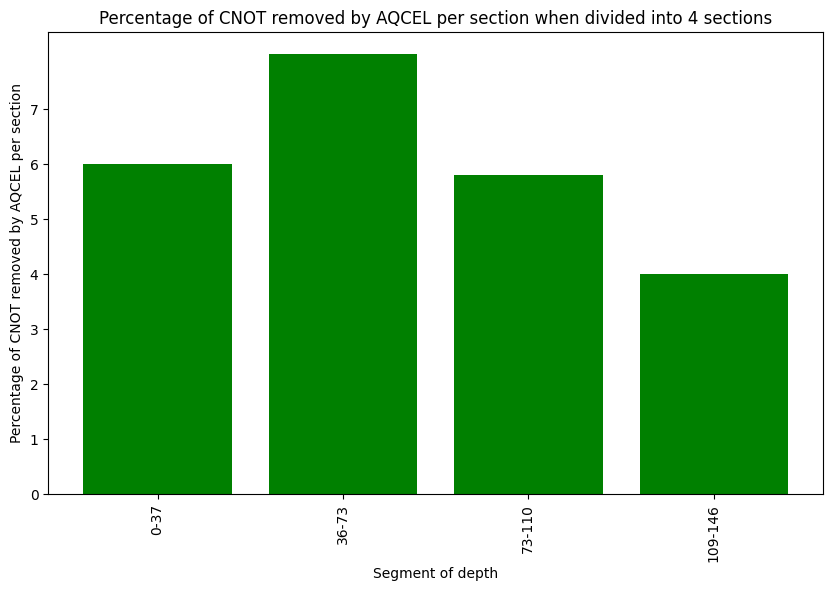

In [19]:
########################################################################################
##### Percentage of CNOT removed by AQCEL per section when divided into 4 sections #####
########################################################################################

# これより上のメッセージは無視してください
# 次のようなグラフを書いてください
# Pythonでmatplotlibを用いてください。ax.は使わずplt.を用いてください
# リスト'depth_ls', 'depth_cnot'の中身はそれぞれCNOTの取り除かれた位置、CNOTの位置(depth）を表しています。リストは自分で用意するのでコードに含めないでください
# depthが0から最大値までの間をM個の区間に区切ってください。ただし、区間の端点は整数になるように区切ってください。また、最初の区間の始点は0になるようにしてください。また、最後の区間では最後の値も含むようにしてください。ここではM=4とします
# depth_lsリストのうち、注目している区間の範囲内にある要素の数をカウントし合計してください。m個あったとします。同じ区間について、今度はdepth_cnotに何個あるかカウントし合計してください。l個とします。あれば横軸（depth)がnに対して高さがm/lとなるような棒グラフを出力してください。ただし、depth_lsに1つも注目している区間の要素が含まれていない場合は高さは0としてください。
# グラフのタイトルは'Percentage of CNOT removed by AQCEL per section when divided into 4 sections'
# グラフのx軸は'Segment of depth'
# グラフのy軸は'Percentage of CNOT removed by AQCEL per section'
# x軸の目盛りは区間の始まりと終わりの値がわかるように表示してください。例えば"0-20"のように表示してください。隣り合う文字がかぶるようなら文字サイズか文字の向きで調整してください。
# y軸の目盛りは0から始めて0.1の倍数ごとに表示してください
# 適切な名前をつけて保存してください。ただし他にも似たようなグラフをたくさん作るので被らないようになるべく細かく指定して名前をつけてください。保存場所は'figures/'です
# グラフの色は緑にしてください
# debugしやすいように、代入した変数全てについてできるだけ細かくprint関数で出力してください。また、printされた値が何かわかるように簡単な説明も一緒にprintしてください。

import matplotlib.pyplot as plt
import numpy as np
import math


# 区間数
M = 4

# 最大値の取得
max_depth = max(max(depth_ls), max(depth_cnot))

# 区間の境界値を計算
bins = np.linspace(0, max_depth, M+1)

# 区間に分けて要素の数をカウント
counts_depth_ls, _ = np.histogram(depth_ls, bins=bins)
counts_depth_cnot, _ = np.histogram(depth_cnot, bins=bins)

# パーセンテージの計算
percentage = [0 if c_cnot == 0 else c_ls/c_cnot for c_ls, c_cnot in zip(counts_depth_ls, counts_depth_cnot)]

# x軸とy軸の値
x = [f'{math.floor(bins[i])}-{math.ceil(bins[i+1])}' for i in range(M)]
y = percentage

# グラフを描画
plt.figure(figsize=(10, 6))
plt.bar(x, y, color='green')

# タイトルと軸のラベルを設定
plt.title('Percentage of CNOT removed by AQCEL per section when divided into 4 sections')
plt.xlabel('Segment of depth')
plt.ylabel('Percentage of CNOT removed by AQCEL per section')

# x軸とy軸の範囲と目盛りを設定
plt.xticks(rotation='vertical')
plt.yticks(np.arange(0, np.nanmax(y), 1))

# グラフを保存
plt.savefig('figures/percentage_cnot_removed_per_section.png', bbox_inches='tight')

# グラフを表示
plt.show()

In [20]:
import plotting_old as pl

# Note: make sure the first counts parameters is g12=1, and the optional counts2 parameter is g12=0.

# Plot the final particle configuration
pl.bar_plot2(counts1, shots, eps, g_1, g_2, counts2= counts0, save=False, wReg=False)

# Plot the number of emissions 
pl.bar_plot_emissions(counts1, shots, eps, g_1, g_2, N, 1, counts2= counts0, save=False, wReg=False)

ModuleNotFoundError: No module named 'plotting_old'